# Task 3 – SHAP-Based Model Explainability
This notebook builds on Task-1 (Data Processing) and Task-2 (Model Training).
Objective:
- Understand *why* our best fraud detection model makes its decisions
- Identify key fraud drivers
- Provide business-ready recommendations


Aligned dataset shape: (151112, 202)
Model features length: 202
Feature importances length: 202


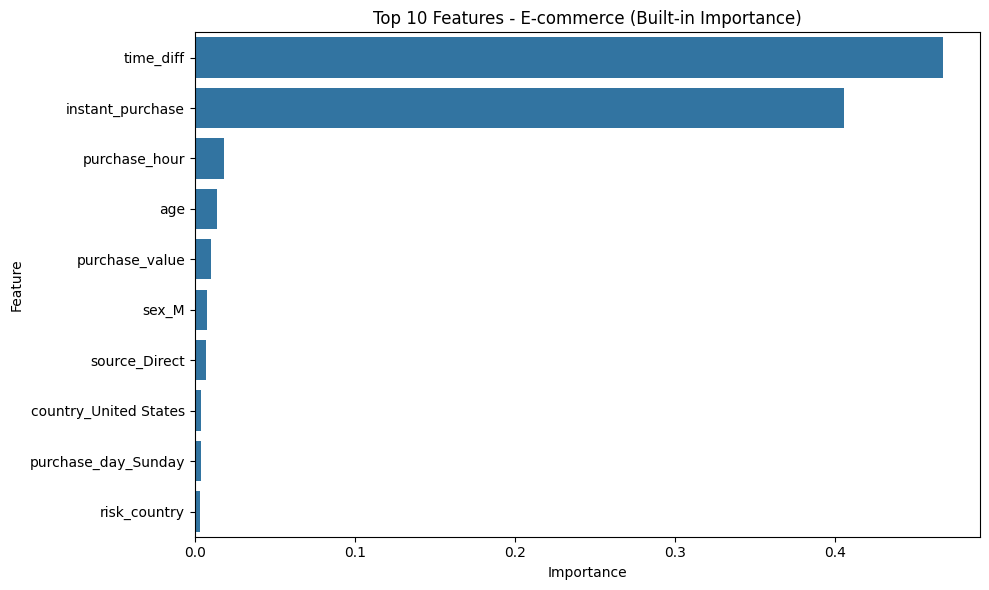

In [ ]:
# -----------------------------
# 0️⃣ Imports
# -----------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# -----------------------------
# 1️⃣ Load processed e-commerce dataset
# -----------------------------
root_dir = "C:/Users/derej/Desktop/Kifya/fraud_detection/"
data_path = os.path.join(root_dir, "data/processed/fraud_data_final.csv")
ecom_df = pd.read_csv(data_path)

# Drop user_id (not used in training)
ecom_df = ecom_df.drop(columns=["user_id"], errors='ignore')

# Separate features and target
ecom_X = ecom_df.drop(columns=["class"])
ecom_y = ecom_df["class"]

# -----------------------------
# 2️⃣ Load trained model
# -----------------------------
model_path = os.path.join(root_dir, "models/ecommerce_best_model.pkl")
ecom_model = joblib.load(model_path)

# -----------------------------
# 3️⃣ Align dataset columns to model
# -----------------------------
if hasattr(ecom_model, "feature_name_"):
    model_features = list(ecom_model.feature_name_)
else:
    model_features = list(ecom_X.columns[:len(ecom_model.feature_importances_)])

# Keep only columns used in training
ecom_X_aligned = ecom_X[model_features]
print("Aligned dataset shape:", ecom_X_aligned.shape)
print("Model features length:", len(model_features))
print("Feature importances length:", len(ecom_model.feature_importances_))

# -----------------------------
# 4️⃣ Built-in Feature Importance
# -----------------------------
feat_imp_ecom = pd.DataFrame({
    "Feature": model_features,
    "Importance": ecom_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_ecom.head(10), x="Importance", y="Feature")
plt.title("Top 10 Features - E-commerce (Built-in Importance)")
plt.tight_layout()
plt.show()

# -----------------------------
# 5️⃣ SHAP Analysis
# -----------------------------
explainer = shap.TreeExplainer(ecom_model)
shap_values = explainer.shap_values(ecom_X_aligned)

# SHAP summary plot
shap.summary_plot(shap_values, ecom_X_aligned, plot_type="bar")

# -----------------------------
# 6️⃣ Select sample for force plots (TP, FP, FN)
# -----------------------------
# Predict on full dataset
y_pred = ecom_model.predict(ecom_X_aligned)

# True Positive, False Positive, False Negative indices
tp_idx = np.where((y_pred == 1) & (ecom_y == 1))[0][0]
fp_idx = np.where((y_pred == 1) & (ecom_y == 0))[0][0]
fn_idx = np.where((y_pred == 0) & (ecom_y == 1))[0][0]

# Use integer indexing for force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[tp_idx,:], 
    ecom_X_aligned.iloc[tp_idx,:], 
    matplotlib=True
)
shap.force_plot(
    explainer.expected_value, 
    shap_values[fp_idx,:], 
    ecom_X_aligned.iloc[fp_idx,:], 
    matplotlib=True
)
shap.force_plot(
    explainer.expected_value, 
    shap_values[fn_idx,:], 
    ecom_X_aligned.iloc[fn_idx,:], 
    matplotlib=True
)

print("✅ E-commerce SHAP analysis completed.")
